## 5-6 评估指标metrics
损失函数除了作为模型训练时候的优化目标，也能够作为模型好坏的一种评价指标。但通常人们还会从其它角度评估模型的好坏。

这就是评估指标。通常损失函数都可以作为评估指标，如MAE,MSE,CategoricalCrossentropy等也是常用的评估指标。

但评估指标不一定可以作为损失函数，例如AUC,Accuracy,Precision。因为评估指标不要求连续可导，而损失函数通常要求连续可导。

编译模型时，可以通过列表形式指定多个评估指标。

如果有需要，也可以自定义评估指标。

自定义评估指标需要接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为评估值。

也可以对tf.keras.metrics.Metric进行子类化，重写初始化方法, update_state方法, result方法实现评估指标的计算逻辑，从而得到评估指标的类的实现形式。

由于训练的过程通常是分批次训练的，而评估指标要跑完一个epoch才能够得到整体的指标结果。因此，类形式的评估指标更为常见。即需要编写初始化方法以创建与计算指标结果相关的一些中间变量，编写update_state方法在每个batch后更新相关中间变量的状态，编写result方法输出最终指标结果。

如果编写函数形式的评估指标，则只能取epoch中各个batch计算的评估指标结果的平均值作为整个epoch上的评估指标结果，这个结果通常会偏离拿整个epoch数据一次计算的结果。

### 一、常用的内置评估指标
* MeanSquaredError（平方差误差，用于回归，可以简写为MSE，函数形式为mse）

* MeanAbsoluteError (绝对值误差，用于回归，可以简写为MAE，函数形式为mae)

* MeanAbsolutePercentageError (平均百分比误差，用于回归，可以简写为MAPE，函数形式为mape)

* RootMeanSquaredError (均方根误差，用于回归)

* Accuracy (准确率，用于分类，可以用字符串"Accuracy"表示，Accuracy=(TP+TN)/(TP+TN+FP+FN)，要求y_true和y_pred都为类别序号编码)

* Precision (精确率，用于二分类，Precision = TP/(TP+FP))

* Recall (召回率，用于二分类，Recall = TP/(TP+FN))

* TruePositives (真正例，用于二分类)

* TrueNegatives (真负例，用于二分类)

* FalsePositives (假正例，用于二分类)

* FalseNegatives (假负例，用于二分类)

* AUC(ROC曲线(TPR vs FPR)下的面积，用于二分类，直观解释为随机抽取一个正样本和一个负样本，正样本的预测值大于负样本的概率)

* CategoricalAccuracy（分类准确率，与Accuracy含义相同，要求y_true(label)为onehot编码形式）

* SparseCategoricalAccuracy (稀疏分类准确率，与Accuracy含义相同，要求y_true(label)为序号编码形式)

* MeanIoU (Intersection-Over-Union，常用于图像分割)

* TopKCategoricalAccuracy (多分类TopK准确率，要求y_true(label)为onehot编码形式)

* SparseTopKCategoricalAccuracy (稀疏多分类TopK准确率，要求y_true(label)为序号编码形式)

* Mean (平均值)

* Sum (求和)

### 二， 自定义评估指标
我们以金融风控领域常用的KS指标为例，示范自定义评估指标。

KS指标适合二分类问题，其计算方式为 KS=max(TPR-FPR).

其中TPR=TP/(TP+FN) , FPR = FP/(FP+TN)

TPR曲线实际上就是正样本的累积分布曲线(CDF)，FPR曲线实际上就是负样本的累积分布曲线(CDF)。

KS指标就是正样本和负样本累积分布曲线差值的最大值。
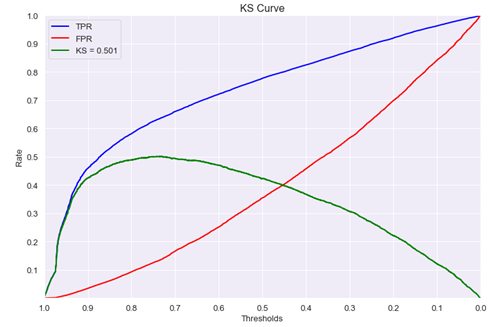

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,metrics

In [2]:
#函数形式的自定义评估指标
@tf.function
def ks(y_true,y_pred):
    y_true = tf.reshape(y_true,(-1,))
    y_pred = tf.reshape(y_pred,(-1,))
    length = tf.shape(y_true)[0]
    t = tf.math.top_k(y_pred,k = length,sorted = False)
    y_pred_sorted = tf.gather(y_pred,t.indices)
    y_true_sorted = tf.gather(y_true,t.indices)
    cum_positive_ratio = tf.truediv(
        tf.cumsum(y_true_sorted),tf.reduce_sum(y_true_sorted))
    cum_negative_ratio = tf.truediv(
        tf.cumsum(1 - y_true_sorted),tf.reduce_sum(1 - y_true_sorted))
    ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
    return ks_value